In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np

import ligo.skymap.io
import healpy as hp
import matplotlib.pyplot as plt

In [3]:



def get_probabilities(skymap, ra, dec, radius=0.35*u.deg):
    """
    Compute the probabilities covered in a grid of ra, dec with radius
    given a healpix skymap

    Pass the legal RA and Dec lists to this function

    Note: this radius is such that for the default sky grid (nside=128),
    fields overlap such that the area of the sky becomes 1.83 * 4pi steradians.
    As a result, the sum of probabilities will be 1.83
    """
    # fact : int, optional
    # Only used when inclusive=True. The overlapping test will be done at
    # the resolution fact*nside. For NESTED ordering, fact must be a power of 2, less than 2**30,
    # else it can be any positive integer. Default: 4.
    fact = 1
    nside_skymap = hp.npix2nside(len(skymap))
    tile_area = np.pi * radius.to(u.deg).value ** 2
    pixel_area = hp.nside2pixarea(nside_skymap, degrees=True)
    probabilities = np.zeros(len(ra))
    vecs = hp.ang2vec(ra.to(u.deg).value, dec.to(u.deg).value, lonlat=True)
    for i in range(len(ra)):
        sel_pix = hp.query_disc(nside_skymap, vecs[i], radius.to(
            u.rad).value, inclusive=True, fact=fact)
        probabilities[i] = np.sum(skymap[sel_pix]) * \
            tile_area / pixel_area / len(sel_pix)
    return probabilities



def get_top_tiles(probabilities, frac=0.99):
    """
    probabilities may not add up to 1
    return indices of tiles that add up to frac of total
    """
    sortorder = np.argsort(probabilities)
    p_cum = np.cumsum(probabilities[sortorder]) / np.sum(probabilities)
    startind = np.where(p_cum > 1 - frac)[0][0]
    top_tiles = sortorder[startind:]
    return np.flip(top_tiles)




tiles = pd.read_csv('tiles_GIT_7.csv')
ralist, declist = np.array(tiles['RA_Center'])*u.deg, np.array(tiles['DEC_Center'])*u.deg




In [4]:
cat2 = pd.read_csv('../../new_reduced_galcat.csv')
new = pd.read_csv('../../missing_mass.csv')
cat2['Dist'] = cat2['DistMpc']

In [5]:
mm = pd.read_csv('../../missing_mass.csv')

In [10]:
np.sum(distfact)

0.0007568403605637319

In [16]:
#xn = 229
xn = 983
nobs = 100
nside_skymap = 512

cs = pd.read_csv('Orderings/Map_{}.csv'.format(xn))
sigma_m_nonempty, sigma_m_empty_nodist, sigma_m_empty_dist = np.array(cs['Filled3D']), np.array(cs['Unfilled2D']), np.array(cs['Unfilled3D'])

order_dist = np.flip(np.argsort(sigma_m_empty_dist)[-nobs:])
order_nodist = np.flip(np.argsort(sigma_m_empty_nodist)[-nobs:])
order_all = np.flip(np.argsort(sigma_m_nonempty)[-nobs:])


radius = 0.35*u.deg
fact = 1
nside_skymap = 512


skym = ligo.skymap.io.fits.read_sky_map('farah/allsky/{}.fits'.format(xn), distances=True)
skymap = hp.ud_grade(skym[0][0], 512)

tiles = pd.read_csv('tiles_GIT_7.csv')
ralist, declist = np.array(tiles['RA_Center'])*u.deg, np.array(tiles['DEC_Center'])*u.deg

distmu = hp.ud_grade(skym[0][1], 512)
distsigma = hp.ud_grade(skym[0][2], 512)
prob2d = hp.ud_grade(skym[0][0], 512)

probs = get_probabilities(skymap, ralist, declist)
ttt = get_top_tiles(probs, 0.99)

badind = np.where((order_all != order_dist) & (order_all == order_nodist))[0]
print(len(badind))
tt = ttt[order_all[badind]]
for h in range(30,40):
    ra = ralist[tt[h]]
    dec = declist[tt[h]]
    
    vecs = hp.ang2vec(ra.to(u.deg).value, dec.to(u.deg).value, lonlat=True)

    sel_pix = hp.query_disc(nside_skymap, vecs, radius.to(u.rad).value, inclusive=True, fact=fact)

    catmass = np.zeros(50)
    fillmass = np.zeros(50)
    #masses3 = np.zeros(len(sel_pix))

    mpcd = np.arange(0,1001,20)
    
    distfact = np.zeros(len(mpcd))

    for t in sel_pix:
        distfact += prob2d[t]/distsigma[t] * np.exp( -(mpcd-distmu[t])**2 / (2*distsigma[t]**2) )
        dfn = cat2[cat2.PIX_ID_512 == t][['Dist','Mstar']]
        for i in range(50):
            dfd = dfn[(dfn.Dist > mm.distmin[i]) & (dfn.Dist <= mm.distmax[i])]
            if len(dfd)==0:
                fillmass[i] += mm.masstofill[i] / mm.num_empty_pixels[i]# * distfact[i]
            else:
                catmass[i] += np.sum(dfd.Mstar)# * distfact[i]
    
    #catmass[:25] = 0
    #catmass[10:13] = np.array([0.1, 0.03, 0.12])*1e12
    #catmass[31:41] = np.array([1.03, 0,0 ,0.7,1.4,0.1,0,0, 0.3, 0.12])*1e12
    #catmass[47:] = np.array([1.6,0.05,0])*1e12
    #catmass /=1.25
    #fillmass *= 2
    plt.plot(np.arange(0,1000,20), np.array(catmass),label='Catalog Mass')
    plt.plot(np.arange(0,1000,20), np.array(fillmass), label='Missing Mass')
    print(np.max(distfact))
    plt.plot(np.arange(0,1000,20), distfact[1:]/np.max(distfact)*np.max(fillmass)*1.31, label='Distance Prob', linestyle='--')
    #plt.title(str(np.round(np.sum(prob2d[sel_pix]),10)))
    plt.title('Tile B')
    #plt.ylim(-0.05e12,2e12)
    plt.legend()
    plt.show()
    
    
    plt.plot(np.arange(0,1000,20), np.cumsum(catmass*distfact[1:]), label='Cumulative $p$ x $m_{cat}$')
    plt.plot(np.arange(0,1000,20), np.cumsum(fillmass*distfact[1:]), label='Cumulative $p$ x $m_{miss}$')
    plt.plot(np.arange(0,1000,20), np.cumsum((fillmass+catmass)*distfact[1:]), label='Cumulative $p$ x $m_{net}$')
    #plt.axhline(np.sum(catmass)*np.sum(distfact[1:]), label='$p_{2D} \times m_{cat, 2D}$')
    print(np.max(distfact))
    #plt.plot(np.arange(0,1000,20), distfact[1:]/np.max(distfact)*np.max(fillmass), color='peru', label='Distance Prob', linestyle='--')
    #plt.title(str(np.round(np.sum(prob2d[sel_pix]),10)))
    plt.title('Tile B '+str(np.round(np.sum(catmass)*np.sum(distfact[1:])/1e9,3)))
    plt.legend()
    #plt.ylim(-0.05e7,1.7e7)
    plt.show()

    prob2d[sel_pix] = 0.0

    
    print(h)

/home/tamojeet/.local/lib/python3.8/site-packages/healpy/pixelfunc.py:1978: RuntimeWarning: invalid value encountered in multiply
  map_out = np.sum(mr * goods, axis=1).astype(type_out)


0


IndexError: index 30 is out of bounds for axis 0 with size 0

In [25]:
order_dist

array([ 25,  78,   5,  24, 116, 242,  27,  54,   6, 119, 131,  51,   2,
       108,  37,   8,  48, 130, 270, 298, 138,  99,  49, 102, 188,   0,
       122, 238,  87,  10,  72, 174,  50, 287, 207,  55, 125, 258,   1,
        28,  40,  66,  93, 243, 357,  39, 159,  53,  67,  75, 161,  84,
       389, 153,  85, 228, 186,  30, 133, 192,  31, 495, 205, 321, 304,
        16, 338,  74,  36, 399,  90, 204, 307, 274, 115, 285,  98,  11,
       135, 113, 250, 134,  97,  73, 176, 123, 263, 145,  77,  58, 256,
       286,  41, 103, 292, 355, 187, 236,  62, 232])

In [27]:
order_nodist

array([ 25,  53,  82,   6, 116,   0,  30, 150,  89,  27, 138, 110, 153,
        65,  36, 125,  63,  48,  37, 242,  64, 108, 171, 154,  31, 167,
        72, 133, 175, 193,  28,  85, 130,  95,  88,  49,  57, 124,  58,
         3, 361, 203,  75,  84, 161, 123,  39,   2, 202,  16, 135, 119,
         1, 234, 111,  52, 187, 292, 211, 372, 102,  24, 201,  66,   5,
       238,  78, 274, 247,  76, 121, 249, 298,  81, 282,  55, 199, 132,
        50, 381,  79, 322, 114,   8, 141, 206, 137, 310, 243, 287, 120,
       179,  92, 400,  73, 136, 256, 332, 299,  74])

In [26]:
order_all

array([ 25,   5,  78,   0,   2,  24,   6,  27, 116,   1,  54, 242,   8,
        37, 119,  10,  51, 131,  48, 108,   3, 138, 130,  49,  28,   4,
        99,  11, 102, 270,  53, 298,  40,  31,  13,  50,  39,  87,  72,
        16,  36, 122,   9, 188,  55,  66, 125,  30,  93,  75,   7, 238,
        84, 174, 207,  85,  67, 287,  20,  14,  74, 258,  41,  90,  18,
        58, 243, 159, 186, 153, 192, 161,  22, 205, 133, 357,  98,  12,
        97, 113,  19,  73, 228,  32,  34,  56,  45, 134,  77,  88, 204,
       389, 123, 135,  62, 103, 115, 304,  65,  15])

In [22]:
np.sum(np.where(order_all==order_nodist)[0])

0

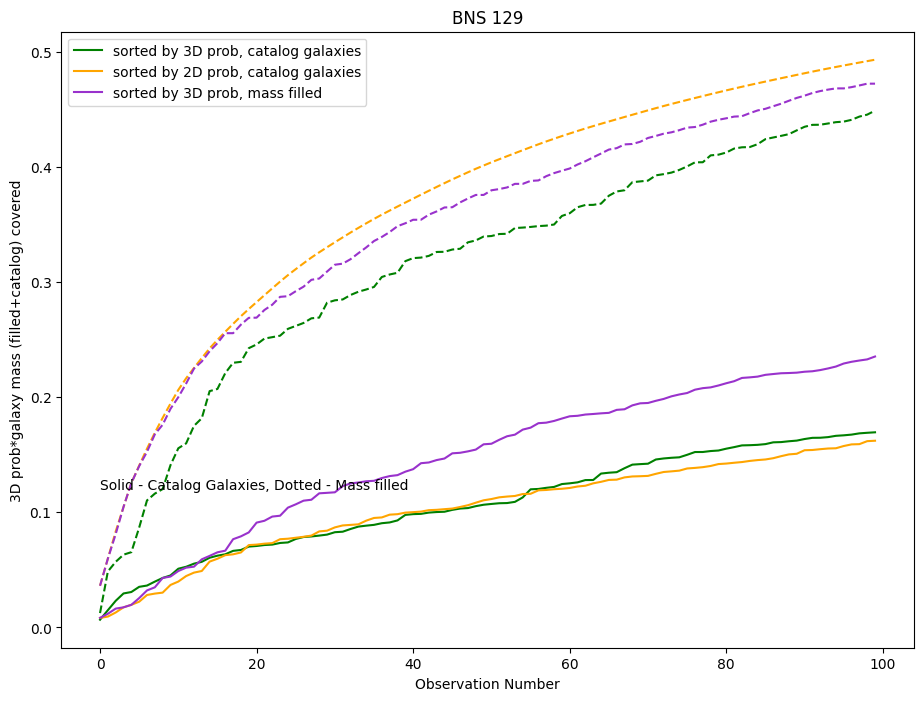

1.3885033042682613


In [3]:
nobs = 100

kl = [33, 40, 55, 77, 88, 111]
#sigma_m = sigma_m[:1008]

for k in [129]:
    cs = pd.read_csv('BNS_GalCat/BNS_{}.csv'.format(k))
    sigma_m_nonempty, sigma_m_empty_nodist, sigma_m_empty_dist = np.array(cs['Filled3D']), np.array(cs['Unfilled2D']), np.array(cs['Unfilled3D'])

    order_dist = np.flip(np.argsort(sigma_m_empty_dist)[-nobs:])
    order_nodist = np.flip(np.argsort(sigma_m_empty_nodist)[-nobs:])
    order_all = np.flip(np.argsort(sigma_m_nonempty)[-nobs:])


    fullsum = np.sum(sigma_m_nonempty)
    a1 = np.cumsum((sigma_m_nonempty-sigma_m_empty_dist)[order_nodist]) / fullsum
    a2 = np.cumsum((sigma_m_nonempty-sigma_m_empty_dist)[order_dist]) / fullsum
    a3 = np.cumsum((sigma_m_nonempty-sigma_m_empty_dist)[order_all]) / fullsum
    
    b1 = np.cumsum((sigma_m_empty_dist)[order_nodist]) / fullsum
    b2 = np.cumsum((sigma_m_empty_dist)[order_dist]) / fullsum
    b3 = np.cumsum((sigma_m_empty_dist)[order_all]) / fullsum


    plt.figure(figsize=(11,8))
    plt.plot(a1, color='green', label='sorted by 3D prob, catalog galaxies')
    plt.plot(a2, color='orange', label = 'sorted by 2D prob, catalog galaxies')
    plt.plot(a3, color='darkorchid', label = 'sorted by 3D prob, mass filled')
    plt.plot(b1, color='green', linestyle='--')
    plt.plot(b2, color='orange', linestyle='--')
    plt.plot(b3, color='darkorchid', linestyle='--')
    plt.legend()
    plt.xlabel('Observation Number')
    plt.ylabel('3D prob*galaxy mass (filled+catalog) covered')
    plt.title('BNS {}'.format(k))
    plt.text(0,0.12, 'Solid - Catalog Galaxies, Dotted - Mass filled')
    plt.show()

    print(a3[-1]/a1[-1])